# Sample model for Bee Images

In [1]:
# Import modules
import os 
import glob 
import numpy as np 
import pandas as pd 
from tqdm import trange

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Loda Data

In [2]:
# Declare variables to store paths strings to data
data_path = "archive/"
df_path = data_path + "bee_data.csv"
img_path = data_path + "bee_imgs/bee_imgs/"

In [3]:
# Load dataframe of bee data
df = pd.read_csv(df_path)
df = df[["subspecies","id","class_id"]]
print(df.head())

          subspecies  id  class_id
0  Italian honey bee   0         5
1  Italian honey bee   1         5
2  Italian honey bee   2         5
3  Italian honey bee   3         5
4  Italian honey bee   4         5


In [4]:
# Load paths of bee images
pic_paths = glob.glob(img_path + "*.png")
pic_paths.sort()
print(pic_paths[:5])

['data/bee_imgs/bee_imgs/0.png', 'data/bee_imgs/bee_imgs/1.png', 'data/bee_imgs/bee_imgs/10.png', 'data/bee_imgs/bee_imgs/100.png', 'data/bee_imgs/bee_imgs/1000.png']


In [5]:
# Declare variable to store "id" and "class_id"
samples = df[["id","class_id"]].values
print(samples)

[[   0    5]
 [   1    5]
 [   2    5]
 ...
 [4741    0]
 [4742    0]
 [4743    0]]


## Data prep

In [6]:
def getSample(sample) -> (np.array, np.array):
    """Load image into np.array and make one-hot target array

    Parameters
    ----------
    sample : np.array
        an row from samples (np.array storing ids and class_ids 
        of bee data)

    Returns
    -------
    img: np.array
        a np.array containing bee image data 
    target: np.array
        a np.array as a one-hot vector expressing bee type
    """

    path, class_id = sample[0], sample[1]
    img = Image.open(img_path+str(path)+".png")
    img = img.resize((80,80)) 
    img = np.array(img)/255
    if img.shape != (80, 80, 3):
        img = img[:,:,:3]

    target = np.zeros(6)
    target[class_id] = 1
    return img, target

def getBatch(samples):
    """Load multiple images into np.array and make one-hot target arrays

    Parameters
    ----------
    samples : np.array
        multiple rows from samples (np.array storing ids and class_ids 
        of bee data)

    Returns
    -------
    imgs: np.array
        a np.array containing multiple bee image data 
    targets: np.array
        a np.array containing multiple one-hot vector expressing bee types
    """   
    imgs, targets = [], []
    for i in range(samples.shape[0]):
        X_sample, y_sample = getSample(samples[i,:])
        imgs.append(X_sample)
        targets.append(y_sample)
    
    imgs = np.concatenate(imgs, axis=0)
    imgs = imgs.reshape(samples.shape[0],80,80,3)
    targets = np.stack(targets, axis=0)
        
    return imgs, targets

(80, 80, 3) (6,)


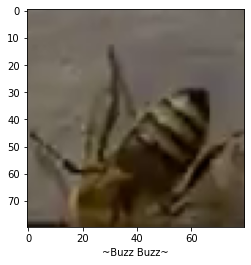

In [7]:
# Test getSample function
X_sample, y_sample = getSample(samples[5,:])
print(X_sample.shape,y_sample.shape)
plt.imshow((X_sample*255).astype(int))
plt.xlabel("~Buzz Buzz~")
plt.show()

(10, 80, 80, 3) (10, 6)


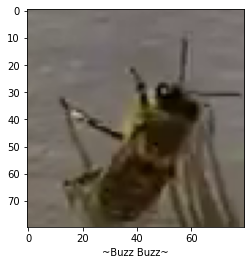

In [8]:
# Test getBatch function
X_sample, y_sample = getBatch(samples[:10,:])
print(X_sample.shape,y_sample.shape)
plt.imshow((X_sample[0,:,:,:]*255).astype(int))
plt.xlabel("~Buzz Buzz~")
plt.show()

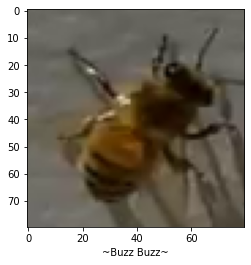

In [9]:
plt.imshow((X_sample[1,:,:,:]*255).astype(int))
plt.xlabel("~Buzz Buzz~")
plt.show()

## Declare model 

In [10]:
class beeCNN(tf.keras.Model):
    def __init__(self,input_shape=(80, 80, 3), **kwargs):
        super(beeCNN, self).__init__(**kwargs)
        self.model = self.getModel(input_shape)
        
    def getModel(self,input_shape):
        inputs = keras.Input(shape=input_shape)
        x = layers.Conv2D(32, (4, 4), activation='relu')(inputs)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Conv2D(64, (3, 3), activation='relu')(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Flatten()(x)
        output = layers.Dense(6, activation="softmax")(x)
        model= tf.keras.Model(inputs,output)
        print(model.summary())
        return model 

    def train_step(self, X, y):
        with tf.GradientTape() as tape:
            yh = self.model(X)
            total_loss = self.loss(y,yh)   
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss,}
    
    def test_step(self, X, y):
        yh = self.model(X)
        total_loss = self.loss(y,yh)  
        return {"loss": total_loss,}
    
    def call(self, X):
        yh = self.model(X)
        return yh

In [11]:
model = beeCNN()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 77, 77, 32)        1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 36, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0         
_________________________________________________________________
dense (Dense)                (None, 6)                 124422

In [12]:
X_sample, y_sample = getBatch(samples[:10,:])
model.train_step(X_sample, y_sample)

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.8579438>}

## Train model

In [13]:
# Shuffle data 
np.random.shuffle(samples)

# Split data
X_train, X_test, y_train, y_test = train_test_split(samples[:,0], samples[:,1], \
                                                    test_size=0.33, random_state=42)

train_data = np.stack((X_train,y_train),axis=1)
test_data = np.stack((X_test,y_test),axis=1)

print(train_data.shape,test_data.shape)

(3178, 2) (1566, 2)


In [14]:
epochs = 25
batch_size = 32

# Train model
for i in range(epochs):
    loss = []
    for j in range(X_train.shape[0]%batch_size):
        X_batch, y_batch = getBatch(train_data[j*(batch_size):(j+1)*batch_size,:])
        l = model.train_step(X_batch, y_batch)
        loss.append(l["loss"])
    print("Epoch: {}, Average loss: {}".format(i, np.mean(loss)))
    np.random.shuffle(train_data)

Epoch: 0, Average loss: 1.1849037408828735
Epoch: 1, Average loss: 0.8068646192550659
Epoch: 2, Average loss: 0.6348509788513184
Epoch: 3, Average loss: 0.6839998960494995
Epoch: 4, Average loss: 0.5740635395050049
Epoch: 5, Average loss: 0.45405763387680054
Epoch: 6, Average loss: 0.40738314390182495
Epoch: 7, Average loss: 0.36320075392723083
Epoch: 8, Average loss: 0.42544785141944885
Epoch: 9, Average loss: 0.3628128468990326
Epoch: 10, Average loss: 0.31422173976898193
Epoch: 11, Average loss: 0.22776922583580017
Epoch: 12, Average loss: 0.21886107325553894
Epoch: 13, Average loss: 0.31119680404663086
Epoch: 14, Average loss: 0.2589775025844574
Epoch: 15, Average loss: 0.22866611182689667
Epoch: 16, Average loss: 0.3176848590373993
Epoch: 17, Average loss: 0.26260969042778015
Epoch: 18, Average loss: 0.2980395555496216
Epoch: 19, Average loss: 0.22516150772571564
Epoch: 20, Average loss: 0.23396196961402893
Epoch: 21, Average loss: 0.2819681167602539
Epoch: 22, Average loss: 0.285

## Test Model

In [15]:
# Test model
X_test, y_test = getBatch(test_data[:,:])
yh = model(X_test)
yh = np.argmax(yh, axis=-1)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [16]:
print("Test acc: ", accuracy_score(np.argmax(y_test, axis=-1), yh))

Test acc:  0.8946360153256705
